In [52]:
# continuing from yesterday
# import the necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the dataset
data = pd.read_csv('ASX200_full.csv', skiprows=[0,1], parse_dates=['Date'], index_col='Date')

## Data Preparation

This section loads the ASX 200 historical data from a CSV file for our analysis.

We'll clean and transform the data to ensure it's properly formatted for financial analysis.

# ASX 200 Market Analysis

This notebook analyzes the Australian Securities Exchange (ASX 200) historical data to uncover market patterns and investment insights.

The analysis will focus on investment strategies and seasonal patterns in market returns.

In [53]:
# verify data types
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8219 entries, 1992-11-23 to 2025-05-30
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 1  8219 non-null   float64
 1   Unnamed: 2  8219 non-null   float64
 2   Unnamed: 3  8219 non-null   float64
 3   Unnamed: 4  8219 non-null   float64
 4   Unnamed: 5  8219 non-null   float64
 5   Unnamed: 6  8219 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 449.5 KB


,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
Date,,,,,,
1992-11-23,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,0
1992-11-24,1458.400024,1458.400024,1458.400024,1458.400024,1458.400024,0
1992-11-25,1467.900024,1467.900024,1467.900024,1467.900024,1467.900024,0
1992-11-26,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,0
1992-11-27,1458.900024,1458.900024,1458.900024,1458.900024,1458.900024,0


In [54]:
# We can already see a range of issues -- columns wrong, all datatypes are objects, at least 1 row of null values, etc. 
data.rename(columns={
    'Unnamed: 1': 'adj_close',
    'Unnamed: 2': 'close',
    'Unnamed: 3': 'high',
    'Unnamed: 4': 'low',
    'Unnamed: 5': 'open',
    'Unnamed: 6': 'volume'
}, inplace=True)

# remove index, check date is datetime with True, lowercase column names, set date as index
data.reset_index(inplace=True)  
print(data['Date'].dtype == 'datetime64[ns]')
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.set_index('date', inplace=True)

True


## Investment Strategy Comparison

We'll compare two popular investment approaches: annual lump-sum investing versus daily dollar-cost averaging (DCA).

This analysis will reveal which strategy would have performed better historically with the same investment amount.

       Strategy  Final Value ($)  Total Invested ($)  Total Return (%)
Annual Lump Sum     78739.338206               34000        131.586289
      Daily DCA     76919.332999               34000        126.233332


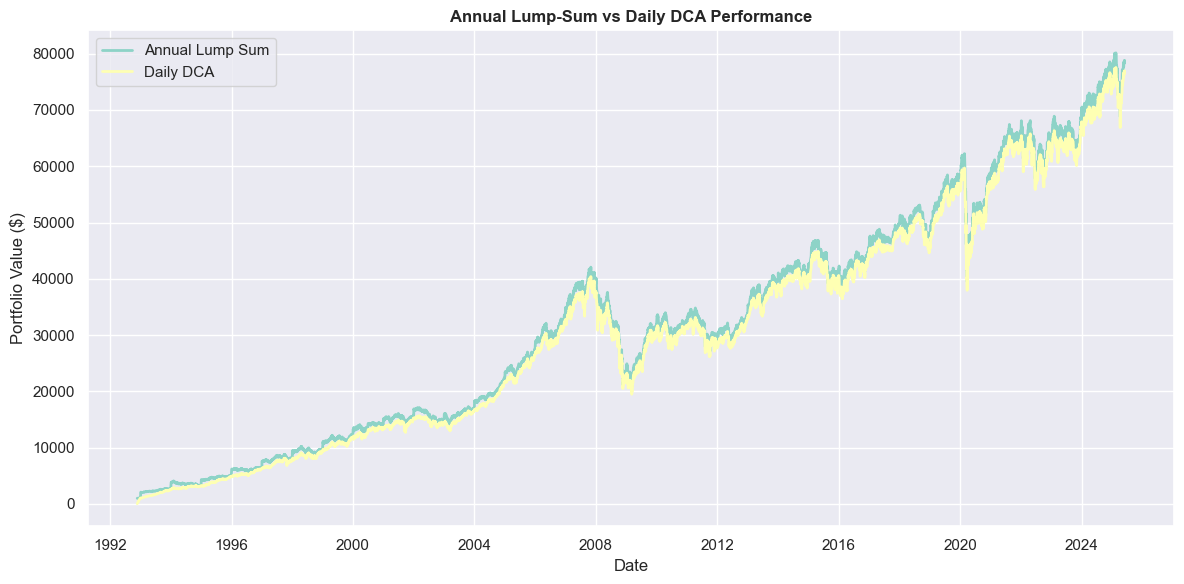

In [64]:
# we've already seen how the ASX has grown over time. Let's look at two different investment strategies:
# annual investment: 
df = data.copy()

# 2. Annual lump‑sum strategy ($1,000 once each January)
df['shares_lump'] = 0.0
cum_shares = 0.0
for year, grp in df.groupby(df.index.year):
    first_day = grp.index.min()
    cum_shares += 1000 / df.at[first_day, 'close']
    df.loc[df.index.year == year, 'shares_lump'] = cum_shares
df['value_lump'] = df['shares_lump'] * df['close']

# 3. Daily DCA strategy ($1,000 spread evenly across trading days each year)
df['shares_daily'] = df.groupby(df.index.year)['close'] \
                       .transform(lambda x: (1000 / len(x)) / x)
df['cum_shares_daily'] = df['shares_daily'].cumsum()
df['value_daily'] = df['cum_shares_daily'] * df['close']

# 4. Final portfolio values & returns
num_years = df.index.year.nunique()
total_invested = num_years * 1000

final_lump  = df['value_lump'].iloc[-1]
final_daily = df['value_daily'].iloc[-1]

total_return_lump  = (final_lump  - total_invested) / total_invested * 100
total_return_daily = (final_daily - total_invested) / total_invested * 100

# 5. Summary table
df_summary = pd.DataFrame({
    'Strategy':           ['Annual Lump Sum', 'Daily DCA'],
    'Final Value ($)':    [final_lump, final_daily],
    'Total Invested ($)': [total_invested, total_invested],
    'Total Return (%)':   [total_return_lump, total_return_daily]
})
print(df_summary.to_string(index=False))

# 6. Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value_lump'],  label='Annual Lump Sum', linewidth=2)
plt.plot(df.index, df['value_daily'], label='Daily DCA',         linewidth=2)
plt.title("Annual Lump-Sum vs Daily DCA Performance", fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.tight_layout()
plt.show()

### Investment Strategy Findings

The comparison shows how timing and frequency of investments impact overall portfolio performance.

Notice the difference in volatility between the two approaches - this reflects the risk profile of each strategy.

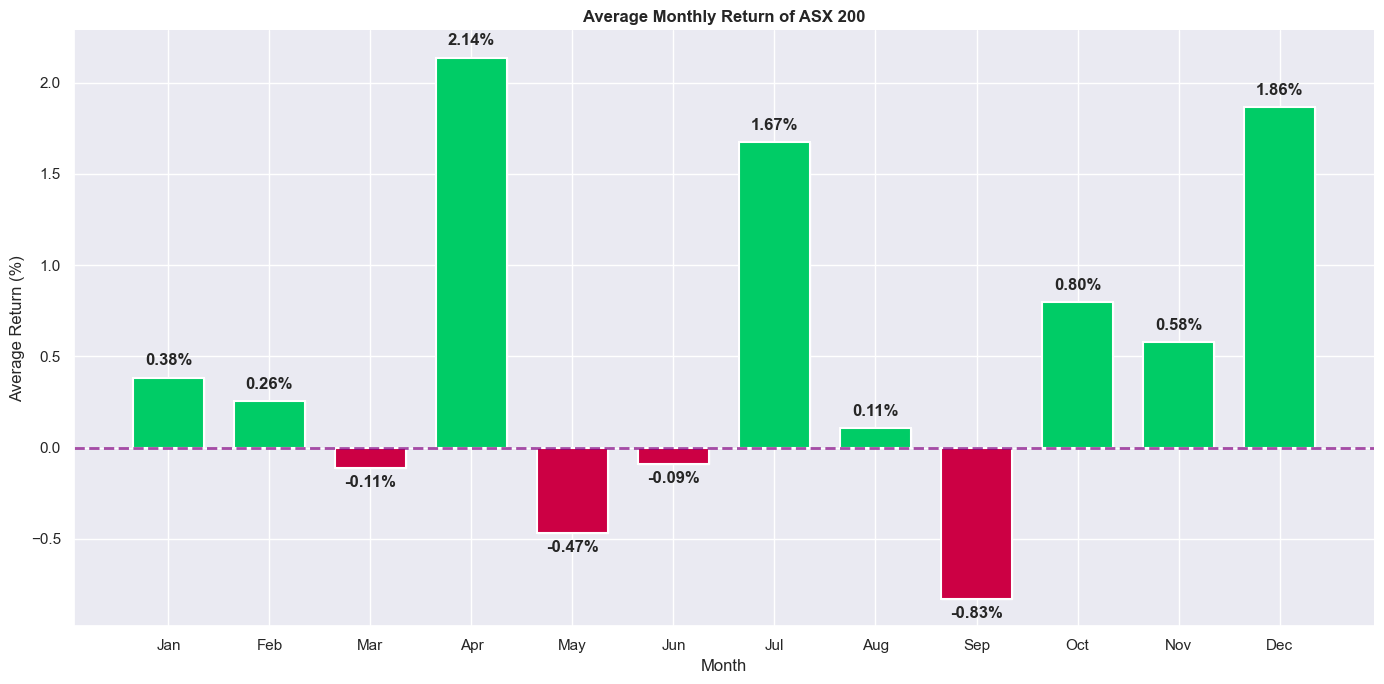

In [62]:
# let's look into something else, what about seasonility ? 
df = data.copy()
import calendar

# 1. Resample to month-end closing price
monthly_close = df['close'].resample('ME').last()

# 2. Calculate monthly returns
monthly_ret = monthly_close.pct_change()

# 3. Average return by calendar month
avg_monthly_return = monthly_ret.groupby(monthly_ret.index.month).mean() * 100

# 4. Plot bar chart
plt.figure(figsize=(14, 7))
sns.set_style('darkgrid')
plt.bar(range(1, 13), avg_monthly_return, color='skyblue', width=0.7)
colors = ['#00cc66' if x > 0 else '#cc0044' for x in avg_monthly_return]  # Darker green and red
bars = plt.bar(range(1, 13), avg_monthly_return, color=colors, width=0.7, 
              edgecolor='white', linewidth=1.5)
              
# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    label_position = height + 0.05 if height > 0 else height - 0.12
    plt.text(bar.get_x() + bar.get_width()/2., label_position,
             f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

# Add x-axis labels with month names
plt.xticks(range(1, 13), list(calendar.month_abbr)[1:])

plt.axhline(0, linewidth=2, linestyle='--', color='purple', alpha=0.7)
plt.title('Average Monthly Return of ASX 200', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Return (%)')
sns.despine()
plt.tight_layout()
plt.show()


## Market Seasonality Analysis

This section examines monthly patterns in ASX 200 returns to identify potential seasonal trends.

Understanding seasonal patterns can provide tactical advantages for timing market entries and exits.

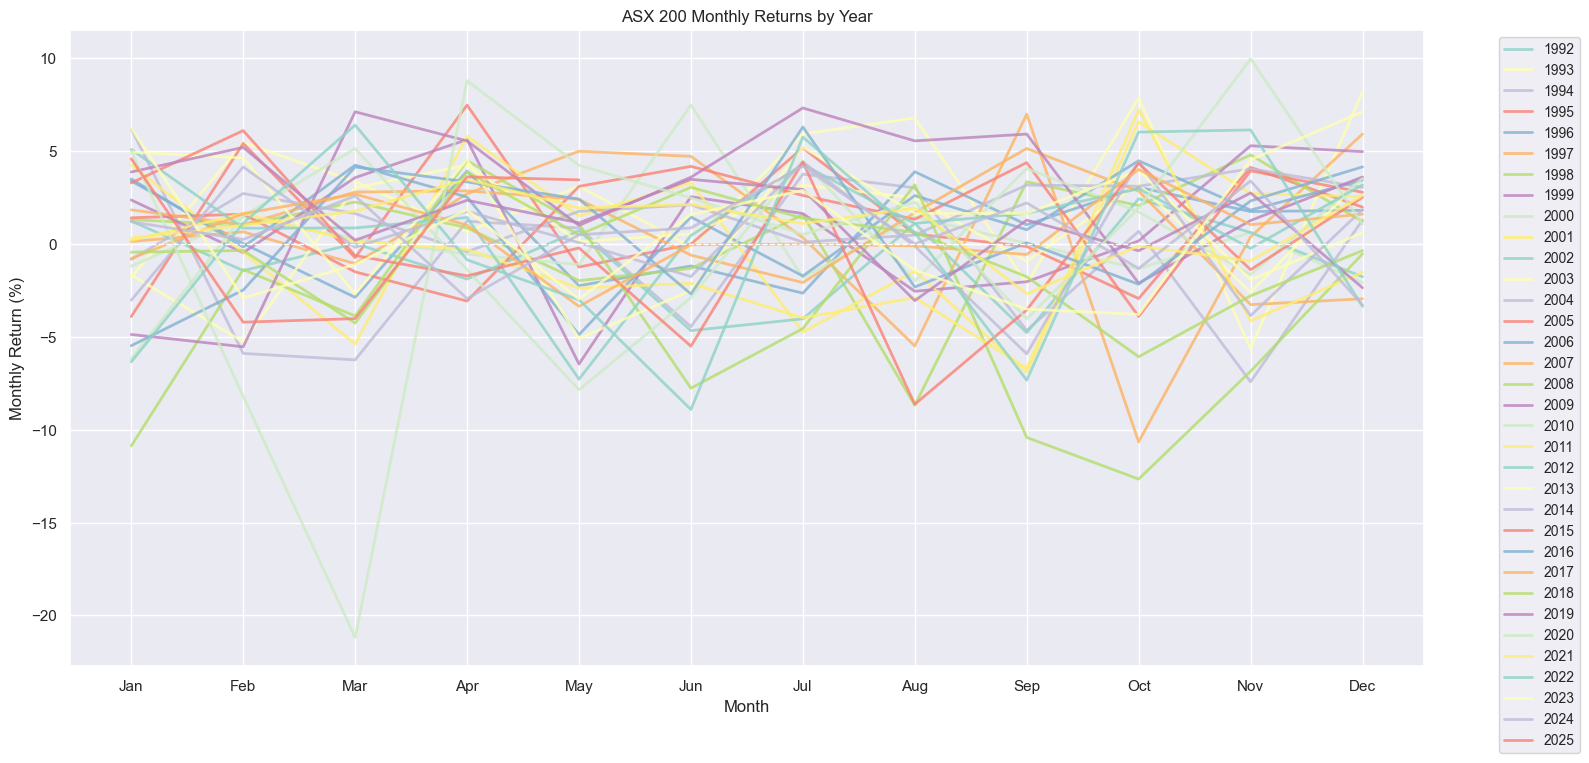

In [58]:
df = data.copy()

# 1. Resample to month-end closing price
monthly_close = df['close'].resample('ME').last()

# 2. Calculate monthly returns and rename series
monthly_ret = monthly_close.pct_change().rename('monthly_ret')

# 3. Prepare DataFrame for pivot
monthly_df = monthly_ret.to_frame().reset_index()
monthly_df['year'] = monthly_df['date'].dt.year
monthly_df['month'] = monthly_df['date'].dt.month

# 4. Pivot: rows = month, cols = year
pivot = monthly_df.pivot(index='month', columns='year', values='monthly_ret')

# 5. Plot each year as a line
plt.figure(figsize=(16, 8))
for yr in pivot.columns:
    plt.plot(pivot.index, pivot[yr] * 100, label=str(yr), linewidth=2, alpha=0.8)

# 6. Formatting
plt.xticks(range(1, 13), list(calendar.month_abbr)[1:])
plt.axhline(0, linestyle='--', linewidth=1)
plt.xlabel('Month')
plt.ylabel('Monthly Return (%)')
plt.title('ASX 200 Monthly Returns by Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small')
plt.tight_layout()
plt.show()


### Monthly Returns Visualization

The bar chart above highlights the average returns for each calendar month across the entire dataset.

Positive months (green) and negative months (red) reveal potential seasonal opportunities and risks.

### Year-by-Year Monthly Performance

The line chart shows monthly returns separated by year, revealing both consistent patterns and anomalies.

This visualization helps distinguish between persistent seasonal effects and one-time market events.

## Conclusion

This analysis reveals important patterns in the ASX 200 market that can guide investment decisions.

Both investment strategy selection and awareness of seasonal patterns can significantly impact investment outcomes.